In [167]:
from  typing import Final
import numpy as np
from scipy.signal import get_window
import matplotlib.pyplot as plt

In [168]:
verbose = False # To view output of arrays, set this to True, useful for understanding code
vt_sim = False # True if making VT graph, false if making IF graph
spike_graphing = False

def verbose_print(message):
    if verbose:
        print(message)

The Leaky Integrate and Fire (LIF) neuronal model

Model Parameters:

In [169]:
# IMPORTANT: Note that the variable names at the end of each line, such as [t] or [dT] are. shorthand variable names  For example, TOTAL_SIMULATION_TIME would typically be represented as T in an equation.
# Reason for verbose variable names was to make it more accessible for the public.

TOTAL_SIMULATION_TIME: Final = 50  # Total duration of simulation in milliseconds [T]
SIMULATION_TIME_INTERVAL: Final = 0.1  # Interval for simulation in milliseconds [dt]
STIMULUS_INITIALIZATION_TIME = 0  # Time in which external stimuli is applied to neuron, measured in milliseconds [t_init]

RESTING_POTENTIAL_VOLTAGE: Final = -70  # Resting membrane potential in mV -- When the neuron is in a stable state [V_rest]
MEMBRANE_RESISTANCE: Final = 1  # Membrane resistance in kOhm -- how much the neuron resists the external stimuli [Rm]
MEMBRANE_CAPACITANCE: Final = 5  # How much charge neurons store. Higher capacitance slows rate at which an action potential is fired, as action potential fires when neuron reaches certain negative threshold, and if the neuron starts at a more positive threshold this will take longer.  Measured in uF [Cm]
REFRACTORY_PERIOD_TIME: Final = 1  # How much time until neuron needs to wait to re-spike after spiking, measured in milliseconds [tau_ref]
SPIKE_THRESHOLD_VOLTAGE: Final = 50  # Membrane potential needed to trigger an action potential  [V_th]
INPUT_CURRENT_AMPLITUDE: Final = 0.2  # Amplitude of external input current in mA [I]
SPIKE_PEAK_VOLTAGE: Final = 50  # What voltage the neuron's action potential reaches at it's peak [V_spike]

Simulation parameters:

In [170]:
# np.arange creates an array of time points for our simulation, specified by (start, stop, step).
# Starting at 0, we increment by the simulation time interval to simulate the neuron's behavior at each step.
# Stop parameter is defined as total simulation time + time interval. This ensures that the final simulation time is included in array. For example, if we did not add the time interval, and we had an interval of 3 and total time of 10, we would stop at time of 9 and never reach 10.

time_array = np.arange(0, TOTAL_SIMULATION_TIME*1e-3 + SIMULATION_TIME_INTERVAL*1e-3,  SIMULATION_TIME_INTERVAL*1e-3)
verbose_print(time_array)

In [171]:
# This initializes the membrane potential array (Vm) to the neuron's resting potential for all time steps.
# To achieve this, we first do np.ones(len(time_array)). We end up with a new array the length of time_array, except this time the entire array consists of 1. We then multiply this new array by the resting potential, making a new array where every value is just the resting potential.

# IMPORTANT: This array initialization serves as a baseline; actual potential values will be updated during the simulation part of the code, namely in the cell In 16, line 8.

# membrane potential is also referred as Vm -- to represent Voltage membrane
membrane_potential_array = np.ones(len(time_array)) * RESTING_POTENTIAL_VOLTAGE*1e-3
verbose_print(membrane_potential_array)

In [172]:
# The membrane time constant [tau_m], refers to the speed at which a neuron's membrane potential returns to equilibrium (resting potential) after a stimuli. Thus, it also is how fast a neuron can respond to a new stimuli.
# Note that spikes are "all or nothing." They cannot be interrupted or prolonged during polarization/depolarization (firing states) or hyperpolarization (recharging state), hence why the value of [tau_m] is so important.

# To calculate:
# 1. Convert membrane resistance [Rm] from kiloohms to ohms by multiplying Rm by 1e3 (1000), as 1 kΩ equals 1000 Ω.
# 2. Convert membrane capacitance [Cm] from microfarads to farads by multiplying [Cm] by 1e-6, since 1 μF equals 1e-6 F.

# Membrane time constant [tau_m] in seconds
membrane_time_constant = MEMBRANE_RESISTANCE*1e3 * MEMBRANE_CAPACITANCE*1e-6
verbose_print(membrane_time_constant)

In [173]:
# We initialize an empty list, which we'll later use to record each time point which a 'spike' occurs.
# Note that a spike occurs when a neuron fires an action potential.
# In the context of the LIF model, a spike occurs when the membrane potential [Vm] reaches or surpasses the spike threshold voltage [V_th]. 

spikes = []

Defining the stimulus:

In [174]:
# The stimulus array models how many Amperes [amps] of electrical current  is provided as external stimuli to the neuron at a given time point
# The reason we're changing the stimulus is to measure the sensitivity of the neuron, and to see at what threshold an action potential is fired

# Notes:
# `INPUT_CURRENT_AMPLITUDE * 1e-3` converts the input current from milliamperes (mA) to amperes (A), since the INPUT_CURRENT_AMPLITUDE is given in mA and 1 mA = 1e-3 (-1000) amperes.

# In signal processing, a 'window' is a way of analyzing a specific segment of the signal instead of the entire thing.
# We form a window the shape of a triangle ('triang'). The length of this triangle is determined by len(time_array), which is the length of the time array.
# The reason we're using a triangle window is to apply a scalar to the amplitude (calculated by `INPUT_CURRENT_AMPLITUDE * 1e-3`). The amplitude is a scalar, but by multiplying it with the triangle window, we're changing the amplitude reaching the neuron at every time point.
# So with the triangular window, the amplitude reaching the neuron first increases linearly, until it reaches a peak. Afterward it starts decreasing linearly.

input_stimulus_array = (INPUT_CURRENT_AMPLITUDE*1e-3 * get_window('triang', len(time_array)))
verbose_print(input_stimulus_array)

Simulation (VT graph):

In [175]:
if vt_sim:
    # Iterate over each time step (interval) in time array, excluding the last index, the notation that does this [:-1] is called negative array indexing in Python
    # The reason we exclude the last index is to prevent the program from going out of bounds
    for index, current_time in enumerate(time_array[:-1]):
        if current_time > STIMULUS_INITIALIZATION_TIME:
            # Calculate the membrane potential for the current time step based on the neuron's resting potential and the input stimulus
            current_membrane_potential_voltage = (RESTING_POTENTIAL_VOLTAGE*1e-3) + (MEMBRANE_RESISTANCE*1e3) * input_stimulus_array[index]
            
            # '(membrane_potential_array[index] - current_membrane_potential_voltage)' is the potential difference of the membrane
            # 'np.exp(-SIMULATION_TIME_INTERVAL * -1e3 / membrane_time_constant)' we're converting the time interval to seconds and then divide it by the membrane time constant [tau_m]. Tau_m measures how long it takes for a membrane to reach 63% of its resting potential.
            membrane_potential_array[index + 1] = current_membrane_potential_voltage + (membrane_potential_array[index] - current_membrane_potential_voltage) * np.exp(-SIMULATION_TIME_INTERVAL*1e-3 / membrane_time_constant)
            
            # Check for spike condition, aka action potential
            if membrane_potential_array[index] >= SPIKE_THRESHOLD_VOLTAGE*1e-3:
                spikes.append(current_time*1e3) # record time of action potential
                membrane_potential_array[index] = SPIKE_PEAK_VOLTAGE*1e-3 # set membrane potential equal to peak voltage to simulate spike
                # After spike, neuron enters hyperpolarization and is not able to spike for a while
                # Refactory Period Time + current time means neuron won't be able to spike until sometime in the future
                STIMULUS_INITIALIZATION_TIME = current_time + REFRACTORY_PERIOD_TIME*1e-3
                
    verbose_print(len(spikes))

Simulation (IF graph):

In [176]:
input_currents = np.arange(0, 2, .1) # Create range of input currents

tau_scalars = [.5,1,2]
firing_rate_dict = {}

if not vt_sim:
    for scalar in tau_scalars:
        firing_rate_dict[scalar] = firing_rate_dict.get(scalar, [])
        for c_input in input_currents:
            STIMULUS_INITIALIZATION_TIME = 0
            spikes = []
            input_stimulus_array = np.full(len(time_array), c_input * 1e-3)
            tau_m = membrane_time_constant * scalar
            
            # reset membrane potential array
            membrane_potential_array = np.ones(len(time_array)) * RESTING_POTENTIAL_VOLTAGE * 1e-3

            
            for index, current_time in enumerate(time_array[:-1]):
                if current_time > STIMULUS_INITIALIZATION_TIME:
                    current_membrane_potential_voltage = (RESTING_POTENTIAL_VOLTAGE*1e-3) + (MEMBRANE_RESISTANCE*1e3) * input_stimulus_array[index]
                    membrane_potential_array[index + 1] = current_membrane_potential_voltage + (membrane_potential_array[index] - current_membrane_potential_voltage) * np.exp(-SIMULATION_TIME_INTERVAL*1e-3 / tau_m)
                    
                    if membrane_potential_array[index] >= SPIKE_THRESHOLD_VOLTAGE*1e-3:
                        spikes.append(current_time*1e3)
                        membrane_potential_array[index] = SPIKE_PEAK_VOLTAGE*1e-3
                        STIMULUS_INITIALIZATION_TIME = current_time + REFRACTORY_PERIOD_TIME*1e-3
                        
            firing_rate = len(spikes) / (TOTAL_SIMULATION_TIME / 1000)
            firing_rate_dict[scalar].append(firing_rate)

Plotting:

In [177]:
if vt_sim:
    plt.figure(figsize=(15,10))
    plt.title('Leaky Integrate-and-Fire Model', fontsize=15) 
    plt.ylabel('Membrane Potential (mV)', fontsize=15) 
    plt.xlabel('Time (ms)', fontsize=15)
    
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    
    
    plt.plot(time_array*1e3, membrane_potential_array*1e3, linewidth=3, label = 'Membrane Potential (Vm)')
    plt.plot(time_array*1e3, (100/max(input_stimulus_array)) * input_stimulus_array, label='Input Stimulus (Scaled)', color='sandybrown', linewidth=2)
    plt.axhline(y=SPIKE_THRESHOLD_VOLTAGE, color='black', linestyle='--', label='Spike Threshold')
    
    if spikes and spike_graphing == True:
            for spike_time in spikes:
                plt.axvline(x=spike_time, c='red', alpha=0.6, linewidth=1, label='Spike' if spikes.index(spike_time) else "_nolegend_")
    
    plt.ylim([-75,100])
    plt.legend()
    plt.show()

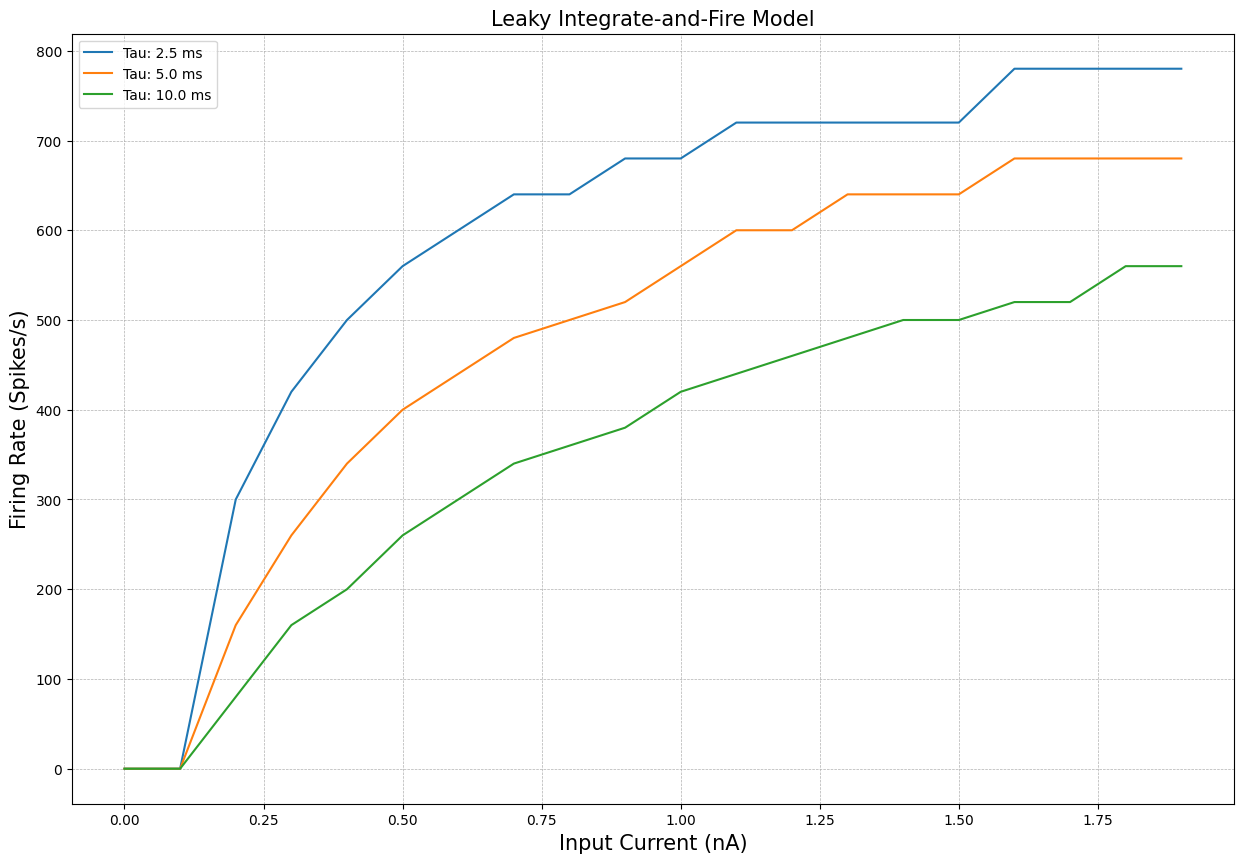

In [178]:
if not vt_sim:
    plt.figure(figsize=(15,10))
    plt.title('Leaky Integrate-and-Fire Model', fontsize=15) 
    plt.ylabel('Firing Rate (Spikes/s)', fontsize=15) 
    plt.xlabel('Input Current (nA)', fontsize=15)
    
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    
    tau_values = [membrane_time_constant * scalar for scalar in tau_scalars]    
    for i, scalar in enumerate(tau_scalars):
        tau_value = tau_values[i] * 1e3 # convert from seconds to ms
        rates = firing_rate_dict[scalar] 
        # plt.plot(input_currents, rates, marker='o', label=f'Scalar: {scalar}, Tau: {tau_value} ms') -- previous plot that also showed scalar constant
        plt.plot(input_currents, rates, label=f'Tau: {tau_value} ms')        
    
    plt.legend()
    plt.show()